Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Phase 2 Project

### Importing Data

In [47]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#### Formatting Cell

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed

In [3]:
df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Glossary

### Column Names and descriptions for Kings County Data Set
(source: Data/column_names.md)
* **id** - unique identified for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  of Bedrooms/House
* **bathrooms** -  of bathrooms/bedrooms
* **sqft_livings** -  footage of the home
* **sqft_lots** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

### Building Condition Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


### Building Grade Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)


Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

## Data Cleaning

### Dropping Uncessary Columns

In [4]:
#df = df.drop(df[['id', 'date', 'view', 'lat', 'long', 'yr_renovated', 'sqft_living15', 'sqft_lot15']], axis=1)
#df.head()

In [5]:
#seeing what the model looks like if I leave in sqft_living15 and sqft_lot15
df = df.drop(df[['id', 'date', 'view', 'lat', 'long', 'yr_renovated']], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


### Checking Data Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     19221 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.5+ MB


#### Removing the ? in sqft_basement

In [7]:
basement_size = df['sqft_basement'].value_counts()
basement_size

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
450.0       103
480.0       103
530.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
1100.0       78
670.0        78
780.0        76
550.0        76
650.0        75
240.0        74
680.0        73
380.0        73
850.0        72
360.0        72
940.0        71
910.0        71
770.0        71
880.0        69
440.0        69
1200.0       69
290.0        69
520.0        68
350.0        68
920.0        66
630.0        66
960.0        65
730.0        65
430.0        64
740.0        64
1010.0       63
760.0        63
640.0        63
340.0        62
560.0        62
570.0        62
280.0        62
950.0        62
820.0        62
790.0        61
460.0        61
1060.0       58
310.0        58
980.0        57
830.0        56
810.0        55
540.0   

In [8]:
unknown_basements = df[df['sqft_basement'] == '?']
known_basements = df[df['sqft_basement'] != '?']

print(len(unknown_basements))
print(len(known_basements))

454
21143


In [9]:
sqft_basement = unknown_basements.apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)
unknown_basements['sqft_basement'] = sqft_basement
unknown_basements.head()

<ipython-input-9-1aa7a46566a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_basements['sqft_basement'] = sqft_basement


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
6,257500.0,3,2.25,1715,6819,2.0,0.0,3,7,1715,0,1995,98003,2238,6819
18,189000.0,2,1.00,1200,9850,1.0,0.0,4,7,1200,0,1921,98002,1060,5095
42,861990.0,5,2.75,3595,5639,2.0,0.0,3,9,3595,0,2014,98053,3625,5639
79,720000.0,4,2.50,3450,39683,2.0,0.0,3,10,3450,0,2002,98010,3350,39750
112,272500.0,3,1.75,1540,12600,1.0,0.0,4,7,1160,380,1980,98038,1540,11656


In [10]:
cleaned_df = known_basements.append(unknown_basements)
cleaned_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


In [11]:
#changing to float so that decminals are in the same format
cleaned_df['sqft_basement'] = cleaned_df['sqft_basement'].astype(float)
cleaned_df['sqft_above'] = cleaned_df['sqft_above'].astype(float)

In [12]:
cleaned_df['sqft_basement'].value_counts().head()

0.0      13110
600.0      221
700.0      218
500.0      214
800.0      206
Name: sqft_basement, dtype: int64

#### Changing Zip Code to Category

In [13]:
print(len(df['zipcode'].value_counts()))

70


In [14]:
cleaned_df['zipcode'] = df['zipcode'].astype(str)

In [15]:
cleaned_df['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

### Dropping Bedroom Outliers

In [16]:
cleaned_df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [17]:
#dropping outliers
cleaned_df = cleaned_df.sort_values('bedrooms', ascending=False).reset_index()
cleaned_df = cleaned_df.drop([0,1,2])
cleaned_df.head(5)

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745
4,13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2008,98004,2730,10400
5,8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1996,98144,1448,3866
6,18428,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,98105,2460,4400
7,4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,98102,1960,2450


In [18]:
#dropping index
cleaned_df = cleaned_df.drop(['index'], axis=1)

In [19]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  int64  
 4   sqft_lot       21594 non-null  int64  
 5   floors         21594 non-null  float64
 6   waterfront     19218 non-null  float64
 7   condition      21594 non-null  int64  
 8   grade          21594 non-null  int64  
 9   sqft_above     21594 non-null  float64
 10  sqft_basement  21594 non-null  float64
 11  yr_built       21594 non-null  int64  
 12  zipcode        21594 non-null  object 
 13  sqft_living15  21594 non-null  int64  
 14  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 2.6+ MB


### Exploring Data with Scatter Plot

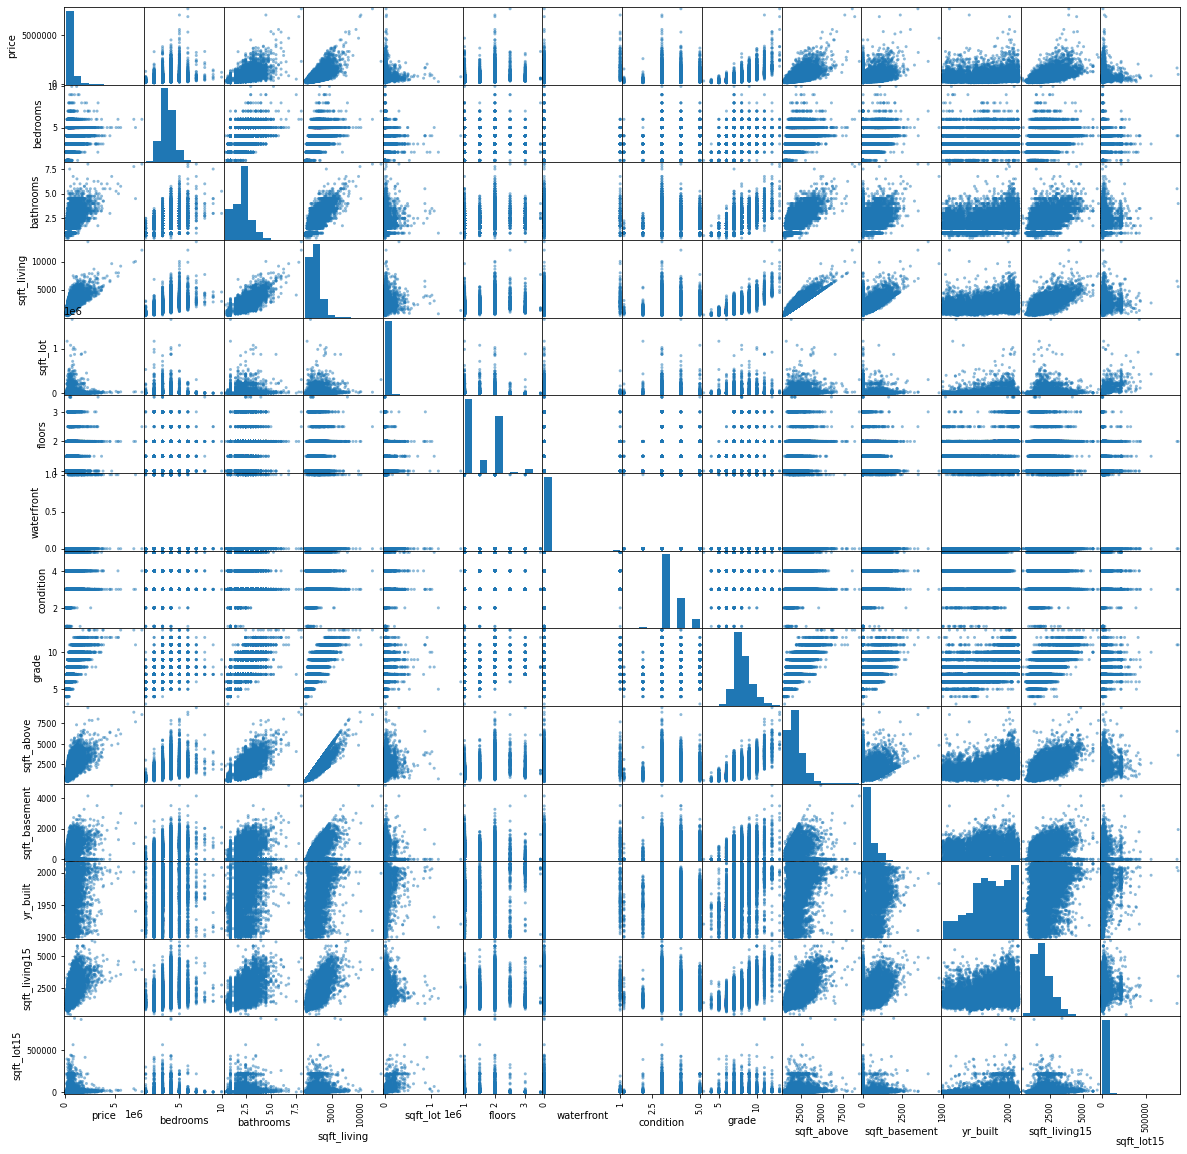

In [20]:
#using scatter plot to look for linear relationships
pd.plotting.scatter_matrix(cleaned_df, figsize = [20,20]);
plt.show()

### Analysis:
At first glance, the following variables seem to have linear relationships:
- price with bedrooms, sqft_above, & sqft_basement.
    - price also seems to have a linear relationship with categorical variable 'grade'.
- bedrooms with bathrooms, sqft_living, sqft_above, & sqft_basement
- sqft_living and sqft_above have the closest linear relationship
    - They are very similar data points. I may need to eliminate one to prevent multicolinearity.
    
The Following Variables seem to be categorical:
- floors
- waterfront
- condition
- zip code (not shown because I have already made it an object)

Ordinal Variables:
- bedrooms
- bathrooms



### What To Do with the Ordinal Values

I am going to treat grade as a continuous variable as it has very linear relationships with many features. Including price.

## Checking for Null Values

In [21]:
cleaned_df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [22]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  int64  
 4   sqft_lot       21594 non-null  int64  
 5   floors         21594 non-null  float64
 6   waterfront     19218 non-null  float64
 7   condition      21594 non-null  int64  
 8   grade          21594 non-null  int64  
 9   sqft_above     21594 non-null  float64
 10  sqft_basement  21594 non-null  float64
 11  yr_built       21594 non-null  int64  
 12  zipcode        21594 non-null  object 
 13  sqft_living15  21594 non-null  int64  
 14  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 2.6+ MB


## Fixing Waterfront

In [23]:
cleaned_df['waterfront'].value_counts()

0.0    19072
1.0      146
Name: waterfront, dtype: int64

In [24]:
waterfront_cleaned = cleaned_df['waterfront'].fillna(0) 

In [25]:
cleaned_df['waterfront'] = waterfront_cleaned

In [26]:
cleaned_df['waterfront'].value_counts()

0.0    21448
1.0      146
Name: waterfront, dtype: int64

In [27]:
cleaned_df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Building Condition

Should I change the condition values from numbers to words?

## Bedrooms

Should I change bedrooms so that there are less options? ie, <1 instead of 0, 0.5, etc

## One Hot Encoding

In [28]:
feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
cleaned_df[feats] = cleaned_df[feats].astype(str)
encoded_df = pd.get_dummies(cleaned_df, drop_first=True)

# Baseline Model
- running a model with the cleaned data.

In [29]:
test_df = encoded_df
test_df.head()

,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,660000.0,3.00,2920,3745,7,1860.0,1060.0,1913,1810,3745,...,0,0,0,0,0,0,0,0,0,0
4,1150000.0,5.25,4590,10920,9,2500.0,2090.0,2008,2730,10400,...,0,0,0,0,0,0,0,0,0,0
5,450000.0,7.50,4050,6504,7,4050.0,0.0,1996,1448,3866,...,0,0,0,0,0,0,0,0,0,0
6,934000.0,3.00,2820,4480,7,1880.0,940.0,1918,2460,4400,...,0,0,0,0,0,0,0,0,0,0
7,700000.0,3.00,3680,4400,7,2830.0,850.0,1908,1960,2450,...,0,0,0,0,0,0,0,0,0,0


In [30]:
X = test_df.drop(['price'], axis=1)
y = test_df['price']

In [31]:
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     893.9
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:41:03   Log-Likelihood:            -2.8999e+05
No. Observations:               21594   AIC:                         5.802e+05
Df Residuals:                   21497   BIC:                         5.809e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.377e+06   1.33e+05     10.328      0.000    1.12e+06    1.64e+06
bathrooms       2.926e+04   2706.532     10.811      0.000     2.4e+04    3.46e+04
sqft_living      117.3067      1.899     61.768      0.000     113.584     121.029
sqft_lot           0.2644      0.039      6.704      0.000       0.187       0.342
grade           6.378e+04   1878.036     33.961      0.000    6.01e+04    6.75e+04
sqft_above        90.7463      1.971     46.031      0.000      86.882      94.610
sqft_basement     26.5600      2.233     11.892      0.000      22.182      30.938
yr_built       -1010.3719     67.535    -14.961      0.000   -1142.746    -877.998
sqft_living15     27.9334      2.933      9.524      0.000      22.185      33.682
sqft_lot15        -0.1677      0.062     -2.704      0.007      -0.289      -0.046
bedrooms_10    -5.087e+05   1.18e+05     -4.327      0.000   -7.39e+05   -2.78e+05
bedrooms_2     -4.329e+04   1.23e+04     -3.527      0.000   -6.73e+04   -1.92e+04
bedrooms_3      -7.86e+04   1.21e+04     -6.475      0.000   -1.02e+05   -5.48e+04
bedrooms_4     -1.211e+05   1.24e+04     -9.767      0.000   -1.45e+05   -9.68e+04
bedrooms_5     -1.343e+05   1.31e+04    -10.222      0.000    -1.6e+05   -1.09e+05
bedrooms_6     -1.495e+05   1.62e+04     -9.244      0.000   -1.81e+05   -1.18e+05
bedrooms_7      -2.59e+05   2.99e+04     -8.655      0.000   -3.18e+05      -2e+05
bedrooms_8     -1.474e+05   4.79e+04     -3.074      0.002   -2.41e+05   -5.34e+04
bedrooms_9     -3.946e+05   6.91e+04     -5.708      0.000    -5.3e+05   -2.59e+05
floors_1.5     -2.433e+04   4563.850     -5.332      0.000   -3.33e+04   -1.54e+04
floors_2.0     -5.134e+04   3792.485    -13.537      0.000   -5.88e+04   -4.39e+04
floors_2.5      4.508e+04   1.37e+04      3.280      0.001    1.81e+04     7.2e+04
floors_3.0       -6.9e+04   8440.494     -8.175      0.000   -8.55e+04   -5.25e+04
floors_3.5      2.443e+04   6.29e+04      0.388      0.698   -9.89e+04    1.48e+05
waterfront_1.0  8.506e+05   1.41e+04     60.121      0.000    8.23e+05    8.78e+05
condition_2     5.856e+04   3.32e+04      1.762      0.078   -6600.140    1.24e+05
condition_3     5.153e+04   3.09e+04      1.669      0.095   -8992.455    1.12e+05
condition_4     6.888e+04   3.09e+04      2.230      0.026    8326.231    1.29e+05
condition_5     1.085e+05   3.11e+04      3.492      0.000    4.76e+04    1.69e+05
zipcode_98002   3.051e+04   1.46e+04      2.089      0.037    1887.916    5.91e+04
zipcode_98003  -1.525e+04   1.31e+04     -1.160      0.246    -4.1e+04    1.05e+04
zipcode_98004   7.593e+05   1.29e+04     58.800      0.000    7.34e+05    7.85e+05
zipcode_98005    2.72e+05   1.56e+04     17.481      0.000    2.41e+05    3.02e+05
zipcode_98006   2.629e+05   1.17e+04     22.536      0.000     2.4e+05    2.86e+05
zipcode_9800

## Test Normalization

In [32]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [33]:
data= test_df
data.head()

,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,660000.0,3.00,2920,3745,7,1860.0,1060.0,1913,1810,3745,...,0,0,0,0,0,0,0,0,0,0
4,1150000.0,5.25,4590,10920,9,2500.0,2090.0,2008,2730,10400,...,0,0,0,0,0,0,0,0,0,0
5,450000.0,7.50,4050,6504,7,4050.0,0.0,1996,1448,3866,...,0,0,0,0,0,0,0,0,0,0
6,934000.0,3.00,2820,4480,7,1880.0,940.0,1918,2460,4400,...,0,0,0,0,0,0,0,0,0,0
7,700000.0,3.00,3680,4400,7,2830.0,850.0,1908,1960,2450,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 98 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21594 non-null  float64
 1   bathrooms       21594 non-null  float64
 2   sqft_living     21594 non-null  int64  
 3   sqft_lot        21594 non-null  int64  
 4   grade           21594 non-null  int64  
 5   sqft_above      21594 non-null  float64
 6   sqft_basement   21594 non-null  float64
 7   yr_built        21594 non-null  int64  
 8   sqft_living15   21594 non-null  int64  
 9   sqft_lot15      21594 non-null  int64  
 10  bedrooms_10     21594 non-null  uint8  
 11  bedrooms_2      21594 non-null  uint8  
 12  bedrooms_3      21594 non-null  uint8  
 13  bedrooms_4      21594 non-null  uint8  
 14  bedrooms_5      21594 non-null  uint8  
 15  bedrooms_6      21594 non-null  uint8  
 16  bedrooms_7      21594 non-null  uint8  
 17  bedrooms_8      21594 non-null 

In [35]:
#data = data.drop('zipcode', axis=1)

In [36]:
df_norm = norm_feat(data)
df_norm.head()

,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.325843,1.149780,0.914699,-0.274184,-0.560838,0.086322,1.735587,-1.974634,-0.257824,-0.330473,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
4,1.659567,4.075621,2.733704,-0.100939,1.143820,0.859503,4.062301,1.259466,1.084747,-0.086488,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
5,-0.245753,7.001462,2.145522,-0.207566,-0.560838,2.732051,-0.658896,0.850948,-0.786096,-0.326037,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
6,1.071640,1.149780,0.805776,-0.256437,-0.560838,0.110484,1.464513,-1.804419,0.690731,-0.306459,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
7,0.434718,1.149780,1.742509,-0.258369,-0.560838,1.258175,1.261208,-2.144850,-0.038927,-0.377950,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057


## Test Model with Test Normalized Data

In [37]:
X = df_norm.drop('price', axis=1)
y = df_norm['price']

In [38]:
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     891.6
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:41:03   Log-Likelihood:                -13303.
No. Observations:               21594   AIC:                         2.680e+04
Df Residuals:                   21497   BIC:                         2.757e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0051      0.004     -1.183      0.237      -0.014       0.003
bathrooms          0.0621      0.006     10.908      0.000       0.051       0.073
sqft_living    -1.049e+12    6.3e+11     -1.664      0.096   -2.29e+12    1.86e+11
sqft_lot           0.0300      0.004      6.735      0.000       0.021       0.039
grade              0.2034      0.006     33.862      0.000       0.192       0.215
sqft_above      9.461e+11   5.68e+11      1.664      0.096   -1.68e+11    2.06e+12
sqft_basement    5.06e+11   3.04e+11      1.664      0.096   -8.99e+10     1.1e+12
yr_built          -0.0804      0.005    -14.868      0.000      -0.091      -0.070
sqft_living15      0.0519      0.005      9.473      0.000       0.041       0.063
sqft_lot15        -0.0127      0.005     -2.743      0.006      -0.022      -0.004
bedrooms_10       -0.0164      0.004     -4.560      0.000      -0.023      -0.009
bedrooms_2        -0.0400      0.011     -3.584      0.000      -0.062      -0.018
bedrooms_3        -0.1068      0.016     -6.484      0.000      -0.139      -0.074
bedrooms_4        -0.1540      0.016     -9.777      0.000      -0.185      -0.123
bedrooms_5        -0.0961      0.009    -10.244      0.000      -0.114      -0.078
bedrooms_6        -0.0451      0.005     -9.159      0.000      -0.055      -0.035
bedrooms_7        -0.0295      0.003     -8.646      0.000      -0.036      -0.023
bedrooms_8        -0.0097      0.003     -3.038      0.002      -0.016      -0.003
bedrooms_9        -0.0177      0.003     -5.639      0.000      -0.024      -0.012
floors_1.5        -0.0191      0.004     -5.392      0.000      -0.026      -0.012
floors_2.0        -0.0681      0.005    -13.567      0.000      -0.078      -0.058
floors_2.5         0.0104      0.003      3.223      0.001       0.004       0.017
floors_3.0        -0.0309      0.004     -8.107      0.000      -0.038      -0.023
floors_3.5         0.0011      0.003      0.347      0.728      -0.005       0.007
waterfront_1.0     0.1899      0.003     60.080      0.000       0.184       0.196
condition_2        0.0140      0.008      1.749      0.080      -0.002       0.030
condition_3        0.0684      0.040      1.702      0.089      -0.010       0.147
condition_4        0.0837      0.037      2.259      0.024       0.011       0.156
condition_5        0.0801      0.023      3.509      0.000       0.035       0.125
zipcode_98002      0.0080      0.004      2.110      0.035       0.001       0.015
zipcode_98003     -0.0047      0.004     -1.148      0.251      -0.013       0.003
zipcode_98004      0.2486      0.004     58.748      0.000       0.240       0.257
zipcode_98005      0.0651      0.004     17.473      0.000       0.058       0.072
zipcode_98006      0.1075      0.005     22.544      0.000       0.098       0.117
zipcode_9800

# Data Exploration

## Checking for Multicolinearity

In [39]:
cleaned_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745


In [40]:
#numeric variables
numeric_vars= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
numeric_vars

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15']

In [41]:
king_preprocessed = cleaned_df.loc[:,numeric_vars]
king_preprocessed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
3,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1810,3745
4,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2730,10400
5,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1448,3866
6,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,2460,4400
7,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1960,2450


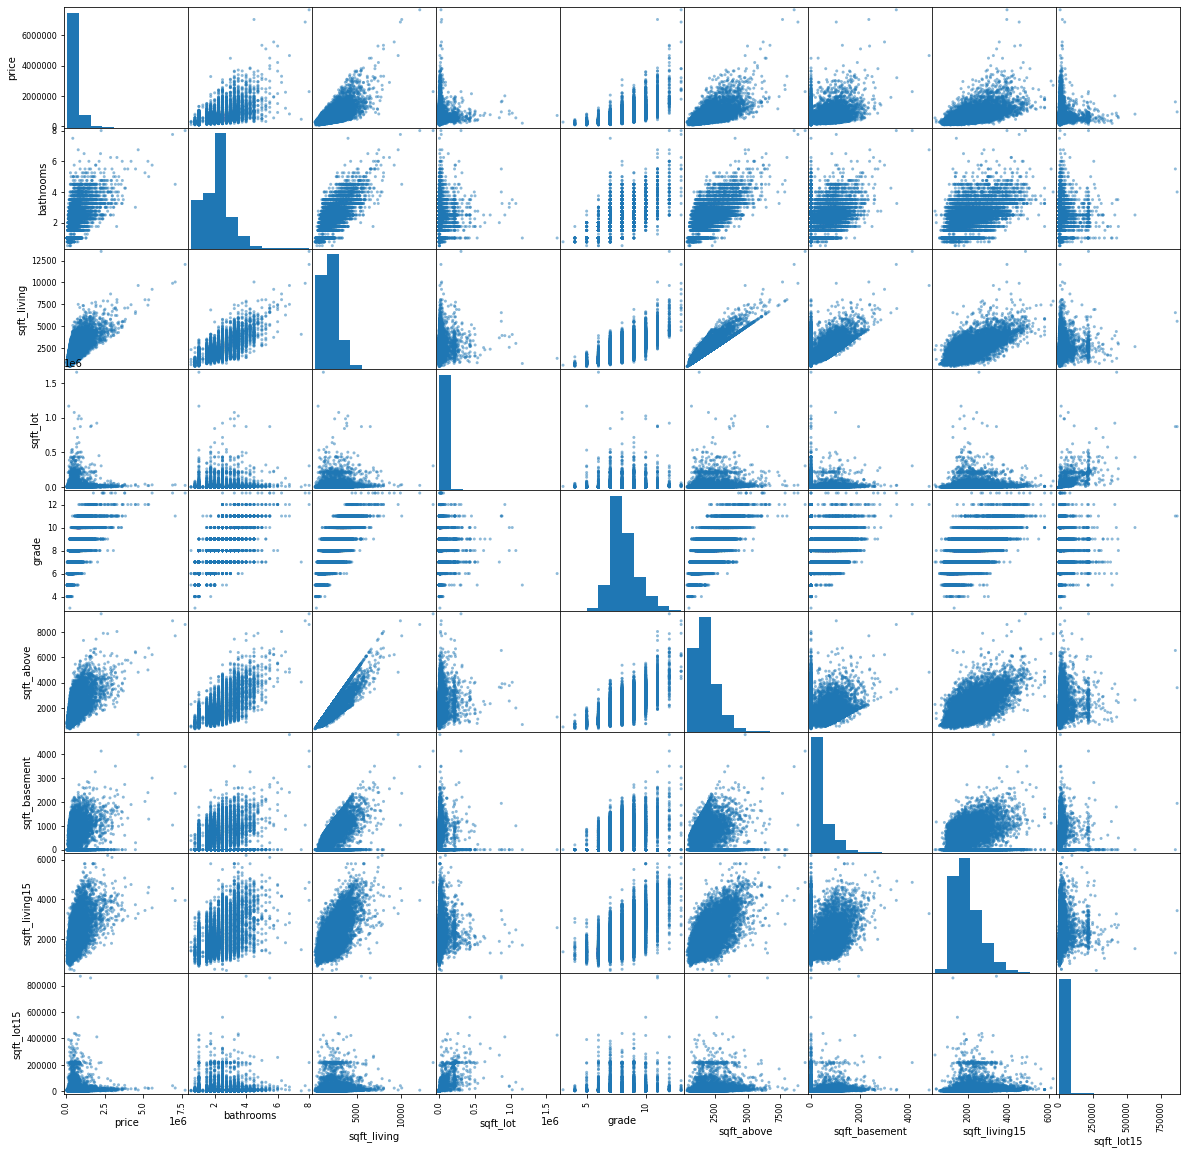

In [42]:
#scatter matrix for numeric variables
pd.plotting.scatter_matrix(king_preprocessed, figsize=[20, 20]);

In [43]:
#correlation matrix
king_preprocessed.corr()

,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
price,1.000000,0.525938,0.701971,0.089880,0.667981,0.605413,0.323795,0.585274,0.082849
bathrooms,0.525938,1.000000,0.755803,0.088384,0.665890,0.686700,0.283441,0.569949,0.088315
sqft_living,0.701971,0.755803,1.000000,0.173482,0.762923,0.876432,0.435114,0.756510,0.184369
sqft_lot,0.089880,0.088384,0.173482,1.000000,0.114720,0.184159,0.015435,0.144749,0.718202
grade,0.667981,0.665890,0.762923,0.114720,1.000000,0.756185,0.168282,0.713865,0.120968
sqft_above,0.605413,0.686700,0.876432,0.184159,0.756185,1.000000,-0.052206,0.731837,0.195094
sqft_basement,0.323795,0.283441,0.435114,0.015435,0.168282,-0.052206,1.000000,0.200510,0.017570
sqft_living15,0.585274,0.569949,0.756510,0.144749,0.713865,0.731837,0.200510,1.000000,0.183499
sqft_lot15,0.082849,0.088315,0.184369,0.718202,0.120968,0.195094,0.017570,0.183499,1.000000


In [44]:
abs(king_preprocessed.corr()) > 0.75

,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
price,True,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False
sqft_living,False,True,True,False,True,True,False,True,False
sqft_lot,False,False,False,True,False,False,False,False,False
grade,False,False,True,False,True,True,False,False,False
sqft_above,False,False,True,False,True,True,False,False,False
sqft_basement,False,False,False,False,False,False,True,False,False
sqft_living15,False,False,True,False,False,False,False,True,False
sqft_lot15,False,False,False,False,False,False,False,False,True


In [49]:
cc_df = king_preprocessed.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876432
"(sqft_living, grade)",0.762923
"(sqft_living, sqft_living15)",0.756510
"(grade, sqft_above)",0.756185
"(sqft_living, bathrooms)",0.755803


I need to remove some of these variables to prevent multicolineartiy. 


### Multicollinearity Analysis

There are 5 sets of variables that are highly correlated.  

In [ ]:
#removing these two variables removes all of the colinearity pairs
#king_preprocessed.drop(columns=['sqft_above', 'sqft_living'], inplace=True)

In [60]:
df_norm.head()

,price,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.325843,1.149780,0.914699,-0.274184,-0.560838,0.086322,1.735587,-1.974634,-0.257824,-0.330473,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
4,1.659567,4.075621,2.733704,-0.100939,1.143820,0.859503,4.062301,1.259466,1.084747,-0.086488,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
5,-0.245753,7.001462,2.145522,-0.207566,-0.560838,2.732051,-0.658896,0.850948,-0.786096,-0.326037,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
6,1.071640,1.149780,0.805776,-0.256437,-0.560838,0.110484,1.464513,-1.804419,0.690731,-0.306459,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
7,0.434718,1.149780,1.742509,-0.258369,-0.560838,1.258175,1.261208,-2.144850,-0.038927,-0.377950,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057


In [61]:
king_preprocessed.drop(columns=['grade', 'sqft_living'], axis=1, inplace=True)

In [55]:
#checking for correlated pairs again
cc_df = king_preprocessed.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

,cc
pairs,


In [57]:
king_preprocessed.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,sqft_living15,sqft_lot15
3,660000.0,10,3.00,3745,2.0,0.0,4,1860.0,1060.0,1810,3745
4,1150000.0,10,5.25,10920,1.0,0.0,3,2500.0,2090.0,2730,10400
5,450000.0,9,7.50,6504,2.0,0.0,3,4050.0,0.0,1448,3866
6,934000.0,9,3.00,4480,2.0,0.0,3,1880.0,940.0,2460,4400
7,700000.0,9,3.00,4400,2.0,0.0,3,2830.0,850.0,1960,2450


## Check VIF Scores!!!!

In [45]:
#def variance_inflation_factors(exog_df):
#    exog_df = add_constant(exog_df)
#    vifs = pd.Series(
#        [1 / (1. - OLS(exog_df[col].values, 
#                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
#         for col in exog_df],
#        index=exog_df.columns,
#        name='VIF'
#    )
#    return vifs

# Model #2
Normalized Data
- Drop grade and sqft_living

In [67]:
#df_norm.drop(columns=['grade', 'sqft_living'], axis=1, inplace=True)
#df_norm.drop([''], axis=1)

In [68]:
df_norm.head()

,price,bathrooms,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,bedrooms_10,bedrooms_2,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.325843,1.149780,-0.274184,0.086322,1.735587,-1.974634,-0.257824,-0.330473,103.901396,-0.382801,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
4,1.659567,4.075621,-0.100939,0.859503,4.062301,1.259466,1.084747,-0.086488,103.901396,-0.382801,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
5,-0.245753,7.001462,-0.207566,2.732051,-0.658896,0.850948,-0.786096,-0.326037,-0.009624,-0.382801,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
6,1.071640,1.149780,-0.256437,0.110484,1.464513,-1.804419,0.690731,-0.306459,-0.009624,-0.382801,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
7,0.434718,1.149780,-0.258369,1.258175,1.261208,-2.144850,-0.038927,-0.377950,-0.009624,-0.382801,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057


In [63]:
X = df_norm.drop('price', axis=1)
y = df_norm['price']

In [64]:
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     845.9
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:56:08   Log-Likelihood:                -13844.
No. Observations:               21594   AIC:                         2.788e+04
Df Residuals:                   21498   BIC:                         2.865e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.824e-15      0.003   2.82e-12      1.000      -0.006       0.006
bathrooms          0.0737      0.006     12.704      0.000       0.062       0.085
sqft_lot           0.0344      0.005      7.533      0.000       0.025       0.043
sqft_above         0.5712      0.007     86.213      0.000       0.558       0.584
sqft_basement      0.2011      0.004     45.373      0.000       0.192       0.210
yr_built          -0.0359      0.005     -6.677      0.000      -0.046      -0.025
sqft_living15      0.1014      0.005     18.727      0.000       0.091       0.112
sqft_lot15        -0.0144      0.005     -3.039      0.002      -0.024      -0.005
bedrooms_10       -0.0146      0.003     -4.627      0.000      -0.021      -0.008
bedrooms_2        -0.0231      0.011     -2.022      0.043      -0.046      -0.001
bedrooms_3        -0.0828      0.017     -4.906      0.000      -0.116      -0.050
bedrooms_4        -0.1407      0.016     -8.719      0.000      -0.172      -0.109
bedrooms_5        -0.0986      0.010    -10.255      0.000      -0.117      -0.080
bedrooms_6        -0.0513      0.005    -10.189      0.000      -0.061      -0.041
bedrooms_7        -0.0336      0.004     -9.608      0.000      -0.041      -0.027
bedrooms_8        -0.0130      0.003     -3.944      0.000      -0.019      -0.007
bedrooms_9        -0.0210      0.003     -6.542      0.000      -0.027      -0.015
floors_1.5        -0.0203      0.004     -5.599      0.000      -0.027      -0.013
floors_2.0        -0.0669      0.005    -13.006      0.000      -0.077      -0.057
floors_2.5         0.0132      0.003      4.012      0.000       0.007       0.020
floors_3.0        -0.0282      0.004     -7.206      0.000      -0.036      -0.021
floors_3.5         0.0017      0.003      0.531      0.595      -0.005       0.008
waterfront_1.0     0.1935      0.003     59.757      0.000       0.187       0.200
condition_2        0.0224      0.008      2.727      0.006       0.006       0.038
condition_3        0.1320      0.041      3.209      0.001       0.051       0.213
condition_4        0.1415      0.038      3.729      0.000       0.067       0.216
condition_5        0.1152      0.023      4.929      0.000       0.069       0.161
zipcode_98002      0.0056      0.004      1.441      0.150      -0.002       0.013
zipcode_98003      0.0006      0.004      0.140      0.889      -0.008       0.009
zipcode_98004      0.2599      0.004     60.068      0.000       0.251       0.268
zipcode_98005      0.0740      0.004     19.422      0.000       0.067       0.081
zipcode_98006      0.1224      0.005     25.144      0.000       0.113       0.132
zipcode_98007      0.0573      0.004     15.507      0.000       0.050       0.065
zipcode_98008      0.0852      0.004     20.380      0.000       0.077       0.093
zipcode_9801

In [ ]:
sns.pairplot(df_norm)

In [ ]:
#sns.heatmap(df_norm);

In [ ]:
#data_pred = df_norm

## Plotting Categoricals and then One-Hot Encoding them

## Dealing with Zip Code
I Need to get Zipcode back in the dataframe so that I can encode it.
Maybe I should do the One Hot Encoding much earlier in my workflow.

In [ ]:
#categoricals = df_norm[['bedrooms', 'bathrooms', 'floors','condition', 'waterfront', 'grade']]

In [ ]:
#categoricals = df_norm[['floors','waterfront', 'grade']]

In [ ]:
#categoricals.head()

In [ ]:
#king_preprocessed

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (king_preprocessed.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()


In [ ]:
#sns.heatmap(categoricals)

In [ ]:
#correlation matrix. 
#df.corr()

In [ ]:
#df_pred_222 = abs(df.corr() > 0.75)

### One Hot Encoding

In [ ]:
feats = ['floors', 'waterfront', 'condition']
feats_df = king_preprocessed[feats].astype(str)
encoded_df = pd.get_dummies(feats_df, drop_first=True)
encoded_df.head()

In [ ]:
df = pd.get_dummies(feats_df, drop_first=True)
df

In [ ]:
df

In [ ]:
pd.get_dummies(feats_df, )

In [ ]:
pd.get_dummies(king_preprocessed.grade)

In [ ]:
#trying sklearn method
ohe = OneHotEncoder(drop='first')

In [ ]:
king_preprocessed.head(1)

In [ ]:
data_trans = ohe.fit_transform(king_preprocessed)
data_trans.todense()

In [ ]:
data_trans = pd.DataFrame(data_trans.todense(), columns=ohe.get_feature_names())
data_trans.head()

# Modeling

# Archive

In [ ]:
#df['waterfront'].value_counts()

In [ ]:
#df['waterfront'] = df['waterfront'].astype('bool') #converting waterfront into boolean

## Resetting IDs to make them shorter

In [ ]:
X = test_df.drop('price', axis=1)
y = test_df['price']

## Should I drop low grade?

In [ ]:
low_grade = cleaned_df[cleaned_df['grade'] <= 5]
low_grade.head()